# Bit-Plane Effects in Image Enhancement
### Course: Image Processing  
### Author: *Farid Nahaie*  
### Tools: Python, OpenCV, NumPy, Matplotlib  

In this experiment, we analyze **bit-plane slicing** and its impact on image enhancement.  
We will:
1. Extract all 8 bit-planes of two 256×256 grayscale images (`Cameraman.png` and `Sinusoidal-Synthetic.png`).
2. Visualize and compare their structures.
3. Reconstruct images using specific bit combinations.
4. Analyze information content using **entropy** and **MSE** metrics.


In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import entropy
from skimage.metrics import mean_squared_error

# Display inline images in notebook
%matplotlib inline


## Step 1 — Load and Prepare Images
We load both images (`Cameraman.png` and `Sinusoidal-Synthetic.png`) in grayscale mode  
and ensure they are resized to **256×256** pixels.


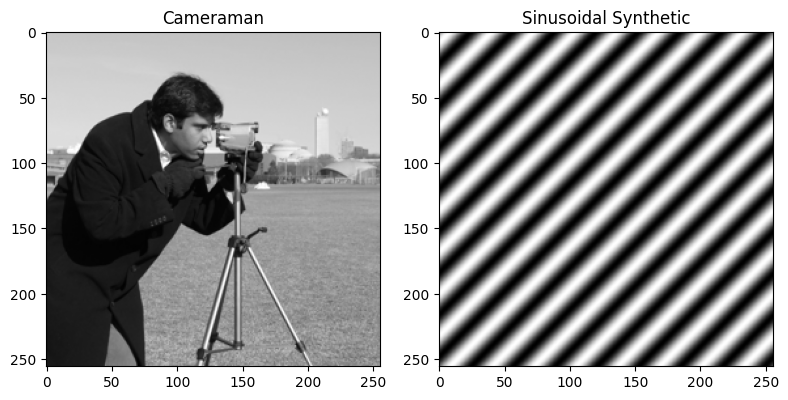

In [5]:
# Load images in grayscale
img_real = cv2.imread('Cameraman.png', cv2.IMREAD_GRAYSCALE)
img_synth = cv2.imread('Sinusoidal-Synthetic.png', cv2.IMREAD_GRAYSCALE)

# Resize to 256×256 (if needed)
img_real = cv2.resize(img_real, (256, 256))
img_synth = cv2.resize(img_synth, (256, 256))

# Display
plt.figure(figsize=(8,4))
plt.subplot(1,2,1); plt.imshow(img_real, cmap='gray'); plt.title("Cameraman")
plt.subplot(1,2,2); plt.imshow(img_synth, cmap='gray'); plt.title("Sinusoidal Synthetic")
plt.tight_layout()
plt.show()


## Step 2 — Bit-Plane Extraction

Each grayscale pixel value \( f(x,y) \in [0,255] \) contains 8 bits.  
The *i-th* bit-plane \( B_i(x,y) \) is extracted by:

\[
B_i(x,y) = \text{bit}_i(f(x,y)) = \frac{f(x,y)}{2^i} \mod 2
\]

We'll create a function to extract all 8 planes for visualization.


In [8]:
def extract_bit_planes(img):
    bit_planes = []
    for i in range(8):
        plane = (img >> i) & 1
        bit_planes.append(plane * 255)
    return bit_planes

bit_planes_real = extract_bit_planes(img_real)
bit_planes_synth = extract_bit_planes(img_synth)


## Step 3 — Visualization of Bit-Planes
The higher-order bits (e.g., B7, B6) usually contain major image structure,  
while lower-order bits (e.g., B0, B1) often capture fine details or noise.


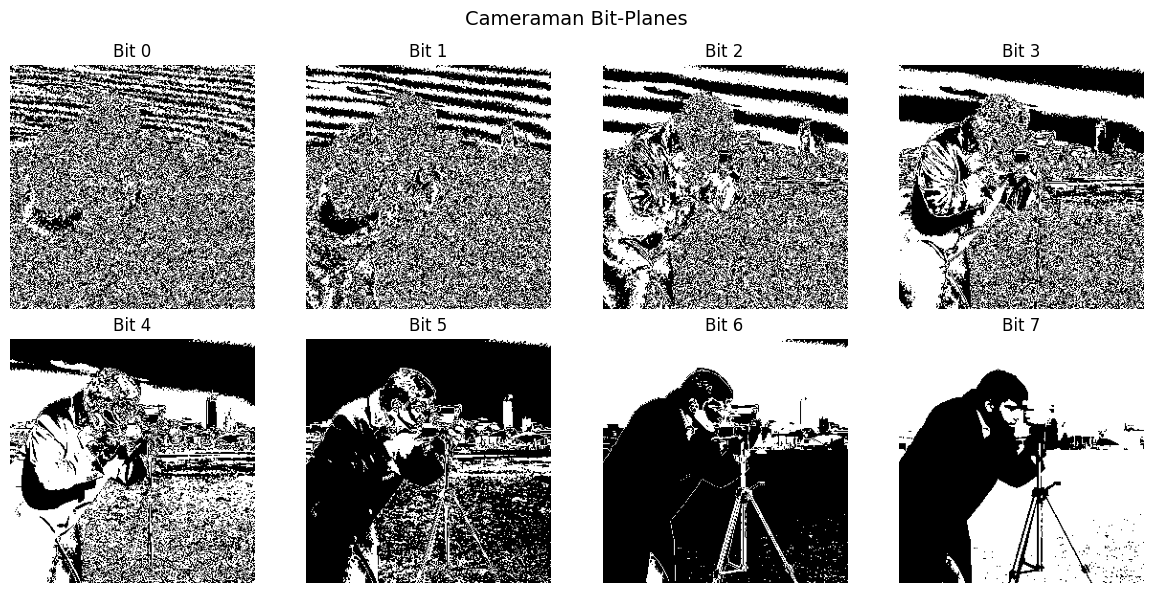

In [7]:
plt.figure(figsize=(12,6))
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.imshow(bit_planes_real[i], cmap='gray')
    plt.title(f"Bit {i}")
    plt.axis('off')
plt.suptitle("Cameraman Bit-Planes", fontsize=14)
plt.tight_layout()
plt.show()


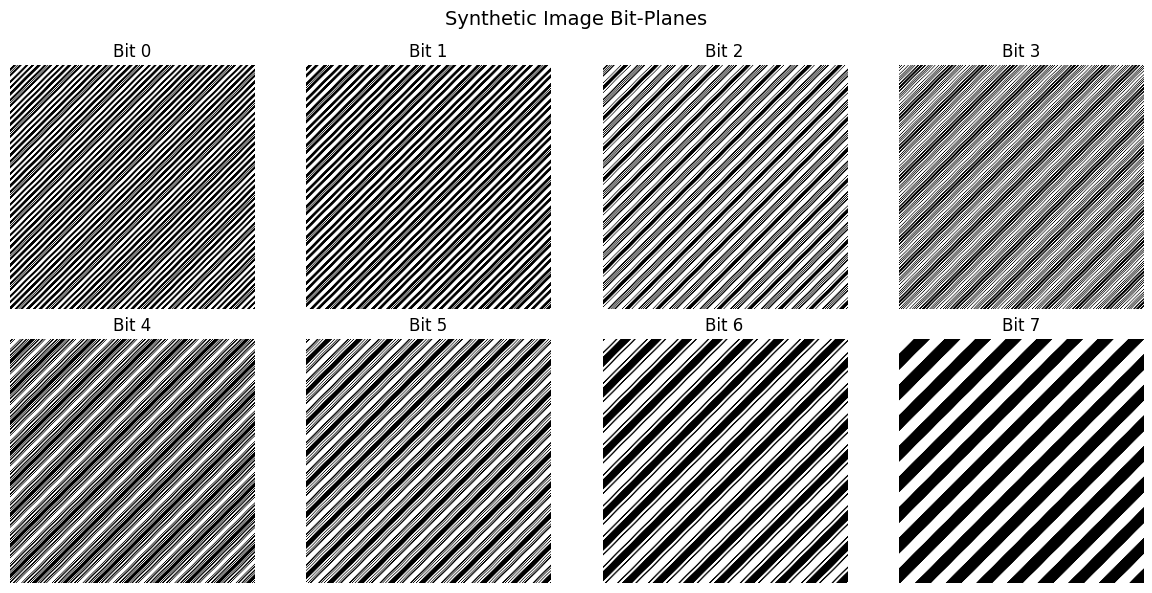

In [9]:
plt.figure(figsize=(12,6))
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.imshow(bit_planes_synth[i], cmap='gray')
    plt.title(f"Bit {i}")
    plt.axis('off')
plt.suptitle("Synthetic Image Bit-Planes", fontsize=14)
plt.tight_layout()
plt.show()


# Histogram

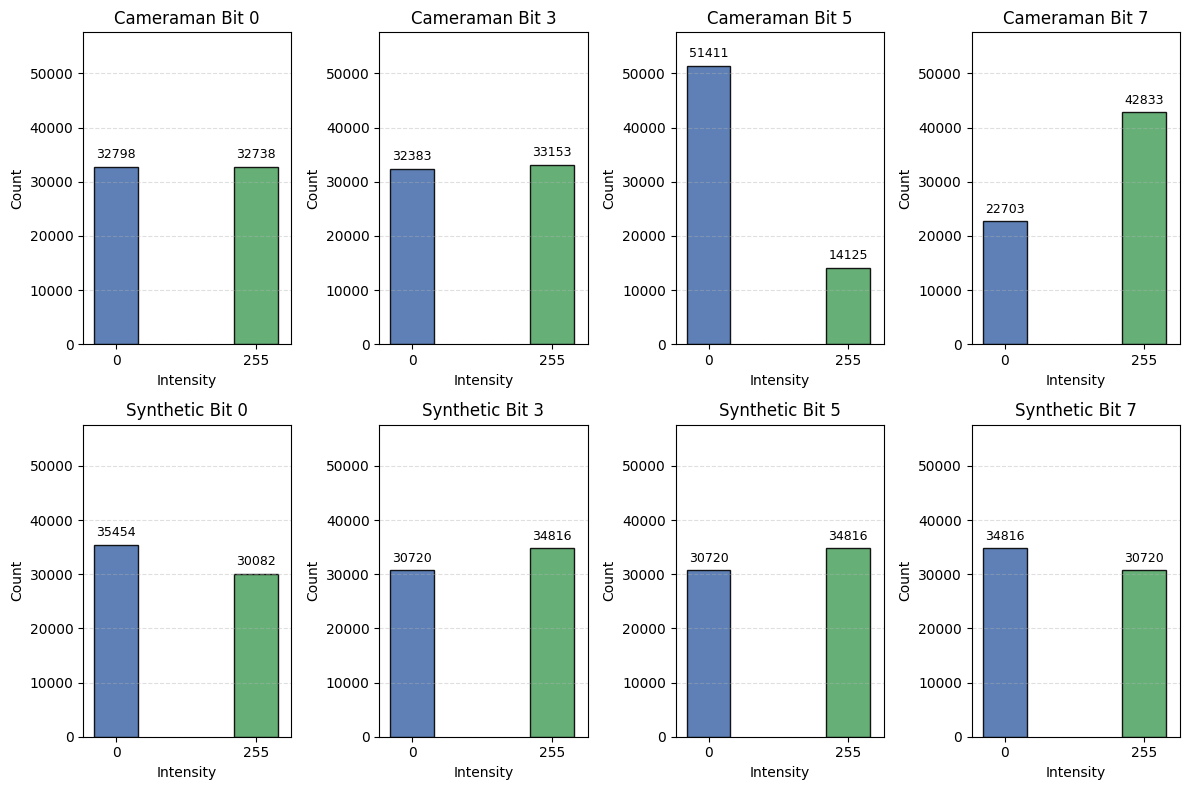

In [ ]:
# Selected bit planes for analysis
selected_bits = [0, 3, 5, 7]

# Compute a global max for y-limits so subplots are comparable
global_max = 0
for bit in selected_bits:
    counts_r = np.bincount((bit_planes_real[bit] // 255).ravel(), minlength=2)
    counts_s = np.bincount((bit_planes_synth[bit] // 255).ravel(), minlength=2)
    global_max = max(global_max, counts_r.max(), counts_s.max())

# Plot histograms as clear bars for both images
plt.figure(figsize=(12, 8))

# Cameraman image histograms (row 1)
for idx, bit in enumerate(selected_bits):
    plt.subplot(2, 4, idx+1)
    counts = np.bincount((bit_planes_real[bit] // 255).ravel(), minlength=2)
    x = np.array([0, 255])
    width = 80
    bars = plt.bar(x, counts, width=width, color=['#4C72B0', '#55A868'], edgecolor='k', alpha=0.9)
    # Annotate counts above bars
    for xi, h in zip(x, counts):
        plt.text(xi, h + max(1, global_max*0.02), str(int(h)), ha='center', va='bottom', fontsize=9)
    plt.title(f"Cameraman Bit {bit}")
    plt.xlabel("Intensity")
    plt.ylabel("Count")
    plt.xticks([0, 255])
    plt.xlim(-60, 320)
    plt.ylim(0, global_max * 1.12)
    plt.grid(axis='y', linestyle='--', alpha=0.4)

# Synthetic image histograms (row 2)
for idx, bit in enumerate(selected_bits):
    plt.subplot(2, 4, idx+5)
    counts = np.bincount((bit_planes_synth[bit] // 255).ravel(), minlength=2)
    x = np.array([0, 255])
    width = 80
    bars = plt.bar(x, counts, width=width, color=['#4C72B0', '#55A868'], edgecolor='k', alpha=0.9)
    for xi, h in zip(x, counts):
        plt.text(xi, h + max(1, global_max*0.02), str(int(h)), ha='center', va='bottom', fontsize=9)
    plt.title(f"Synthetic Bit {bit}")
    plt.xlabel("Intensity")
    plt.ylabel("Count")
    plt.xticks([0, 255])
    plt.xlim(-60, 320)
    plt.ylim(0, global_max * 1.12)
    plt.grid(axis='y', linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()


## Step 4 — Reconstruct Image from Selected Bit-Planes
We reconstruct both images using only bit-planes **{7, 5, 3, 0}**  
to observe the effect of selective combination.


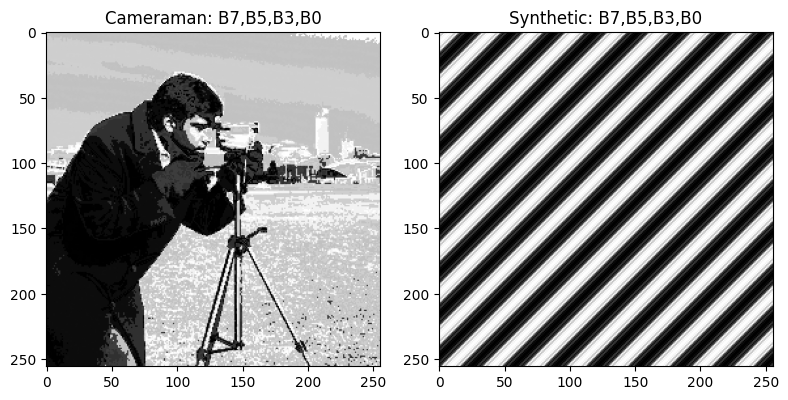

In [10]:
def reconstruct_from_bits(img, bit_indices):
    result = np.zeros_like(img, dtype=np.uint8)
    for i in bit_indices:
        result += ((img >> i) & 1) * (2 ** i)
    return result

subset_bits = [7,5,3,0]
recon_real = reconstruct_from_bits(img_real, subset_bits)
recon_synth = reconstruct_from_bits(img_synth, subset_bits)

plt.figure(figsize=(8,4))
plt.subplot(1,2,1); plt.imshow(recon_real, cmap='gray'); plt.title("Cameraman: B7,B5,B3,B0")
plt.subplot(1,2,2); plt.imshow(recon_synth, cmap='gray'); plt.title("Synthetic: B7,B5,B3,B0")
plt.tight_layout()
plt.show()


## Step 5 — Quantitative Analysis
To measure which bit-planes carry more information, we compute:

1. **Entropy** — Higher entropy ⇒ more information.  
2. **MSE** — Reconstruction error compared to original image.

We plot entropy for each bit-plane for both images.


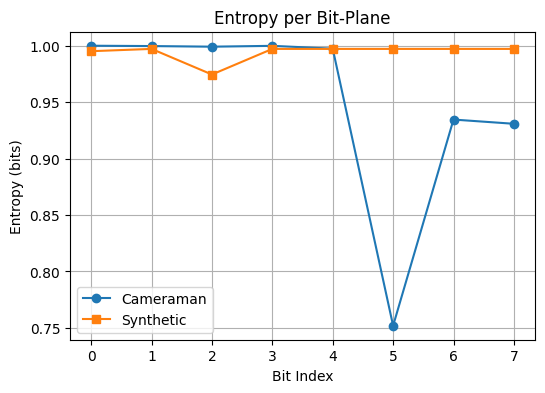

In [11]:
def bit_plane_entropy(bit_planes):
    ent = []
    for bp in bit_planes:
        hist, _ = np.histogram(bp.flatten(), bins=2, range=(0,255))
        ent.append(entropy(hist + 1e-9, base=2))
    return ent

ent_real = bit_plane_entropy(bit_planes_real)
ent_synth = bit_plane_entropy(bit_planes_synth)

plt.figure(figsize=(6,4))
plt.plot(range(8), ent_real, 'o-', label='Cameraman')
plt.plot(range(8), ent_synth, 's-', label='Synthetic')
plt.title("Entropy per Bit-Plane")
plt.xlabel("Bit Index")
plt.ylabel("Entropy (bits)")
plt.legend()
plt.grid(True)
plt.show()


## Step 6 — Cumulative Reconstruction Quality
We gradually add bit-planes (from LSB to MSB)  
and measure the **Mean Squared Error (MSE)** between reconstructed and original image.


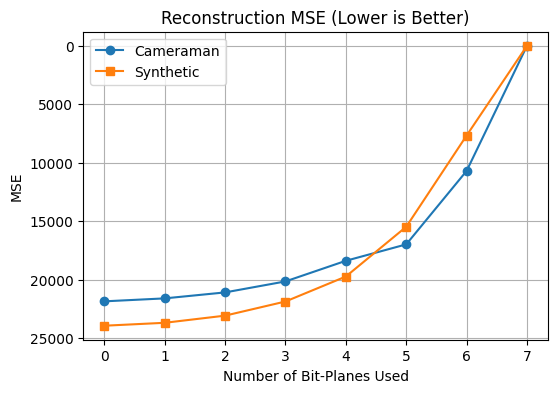

In [12]:
def reconstruction_quality(img):
    mse_vals = []
    for i in range(8):
        bits = list(range(i+1))
        recon = reconstruct_from_bits(img, bits)
        mse = mean_squared_error(img, recon)
        mse_vals.append(mse)
    return mse_vals

mse_real = reconstruction_quality(img_real)
mse_synth = reconstruction_quality(img_synth)

plt.figure(figsize=(6,4))
plt.plot(range(8), mse_real, 'o-', label='Cameraman')
plt.plot(range(8), mse_synth, 's-', label='Synthetic')
plt.gca().invert_yaxis()  # Lower MSE = better
plt.title("Reconstruction MSE (Lower is Better)")
plt.xlabel("Number of Bit-Planes Used")
plt.ylabel("MSE")
plt.legend()
plt.grid(True)
plt.show()


## Step 7 — Discussion

**1. Which bit-planes carry most information?**  
The higher planes (B7–B5) dominate the structural information, while the lower planes add fine detail or noise.

**2. Difference between natural and synthetic images:**  
The synthetic image (sinusoidal) distributes information more evenly across bit-planes,  
while the natural image concentrates most structure in higher bits.

**3. Usefulness of Bit-Plane Analysis:**  
- Image compression (prioritize MSB planes).  
- Data hiding (steganography using LSB).  
- Edge detection and contrast enhancement.  

---

✅ *Result:* Bit-plane decomposition provides both a visual and quantitative insight  
into how information is distributed across image bits, and can be leveraged for  
optimization in image processing pipelines.


---

# Part 2 
## Step 1: Reconstruct images from selected pit planes

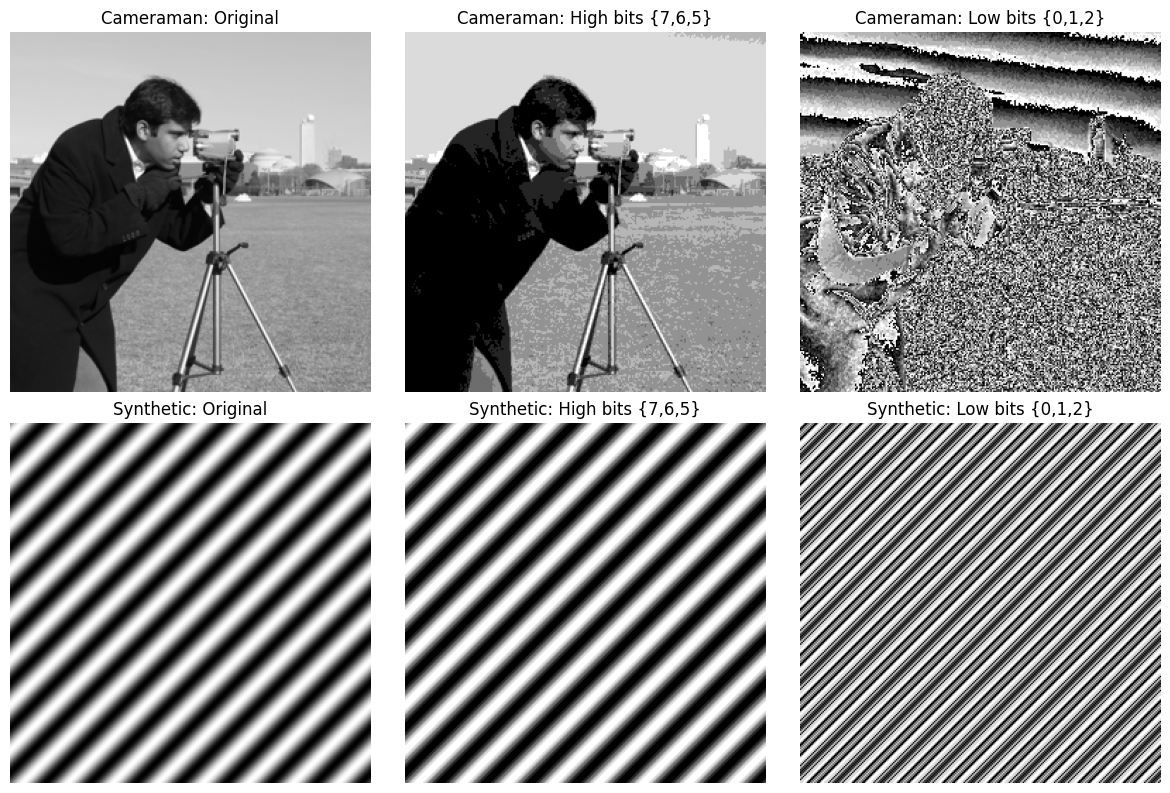

In [6]:
def reconstruct_from_bits(img, bit_indices):
    result = np.zeros_like(img, dtype=np.uint8)
    for i in bit_indices:
        result += ((img >> i) & 1) * (2 ** i)
    return result

# Reconstruct using two sets: high bits {7,6,5} and low bits {0,1,2}
high_bits = [7, 6, 5]
low_bits = [0, 1, 2]

recon_high_real = reconstruct_from_bits(img_real, high_bits)
recon_low_real = reconstruct_from_bits(img_real, low_bits)
recon_high_synth = reconstruct_from_bits(img_synth, high_bits)
recon_low_synth = reconstruct_from_bits(img_synth, low_bits)

# Plot originals and reconstructions (2 rows x 3 columns)
plt.figure(figsize=(12, 8))

# Cameraman row
plt.subplot(2, 3, 1); plt.imshow(img_real, cmap='gray'); plt.title('Cameraman: Original'); plt.axis('off')
plt.subplot(2, 3, 2); plt.imshow(recon_high_real, cmap='gray'); plt.title('Cameraman: High bits {7,6,5}'); plt.axis('off')
plt.subplot(2, 3, 3); plt.imshow(recon_low_real, cmap='gray'); plt.title('Cameraman: Low bits {0,1,2}'); plt.axis('off')

# Synthetic row
plt.subplot(2, 3, 4); plt.imshow(img_synth, cmap='gray'); plt.title('Synthetic: Original'); plt.axis('off')
plt.subplot(2, 3, 5); plt.imshow(recon_high_synth, cmap='gray'); plt.title('Synthetic: High bits {7,6,5}'); plt.axis('off')
plt.subplot(2, 3, 6); plt.imshow(recon_low_synth, cmap='gray'); plt.title('Synthetic: Low bits {0,1,2}'); plt.axis('off')

plt.tight_layout()
plt.show()

## Step 2: MSE / PSNR / Entropy for Selected Reconstructions

In [7]:
# Metrics for the reconstructed images (high and low bit sets)
from IPython.display import display, Markdown
import pandas as pd

def compute_metrics(orig, recon):
    mse = mean_squared_error(orig, recon)
    psnr = 10 * np.log10((255.0 ** 2) / mse) if mse > 0 else np.inf
    hist, _ = np.histogram(recon.flatten(), bins=256, range=(0, 255))
    ent = entropy(hist + 1e-9, base=2)
    return mse, psnr, ent

rows = []
rows.append(("Cameraman", "High {7,6,5}") + compute_metrics(img_real, recon_high_real))
rows.append(("Cameraman", "Low {0,1,2}") + compute_metrics(img_real, recon_low_real))
rows.append(("Synthetic", "High {7,6,5}") + compute_metrics(img_synth, recon_high_synth))
rows.append(("Synthetic", "Low {0,1,2}") + compute_metrics(img_synth, recon_low_synth))

df_metrics = pd.DataFrame(rows, columns=["Image", "Set", "MSE", "PSNR(dB)", "Entropy(bits)"])
# Round for display
df_metrics[["MSE","PSNR(dB)","Entropy(bits)"]] = df_metrics[["MSE","PSNR(dB)","Entropy(bits)"]].round(4)
display(df_metrics)

,Image,Set,MSE,PSNR(dB),Entropy(bits)
0,Cameraman,"High {7,6,5}",348.0726,22.7141,2.4627
1,Cameraman,"Low {0,1,2}",21102.1338,4.8875,2.9985
2,Synthetic,"High {7,6,5}",329.8749,22.9473,2.8343
3,Synthetic,"Low {0,1,2}",23090.0000,4.4966,2.8004


## Step 3: K = [1, 2, 3, 4, 5, 6, 7, 8, 9] for each pit-plane

In [8]:
from IPython.display import display, Markdown
import pandas as pd
import numpy as np
from scipy.stats import entropy
from skimage.metrics import mean_squared_error


results = []
for k in range(1, 9):
    bits = list(range(k))
    recon_r = reconstruct_from_bits(img_real, bits)
    recon_s = reconstruct_from_bits(img_synth, bits)

    mse_r = mean_squared_error(img_real, recon_r)
    mse_s = mean_squared_error(img_synth, recon_s)

    psnr_r = 10 * np.log10((255.0 **  2) / mse_r) if mse_r > 0 else np.inf
    psnr_s = 10 * np.log10((255.0 ** 2) / mse_s) if mse_s > 0 else np.inf

    hist_r, _ = np.histogram(recon_r.flatten(), bins=256, range=(0, 255))
    hist_s, _ = np.histogram(recon_s.flatten(), bins=256, range=(0, 255))
    ent_r = entropy(hist_r + 1e-9, base=2)
    ent_s = entropy(hist_s + 1e-9, base=2)

    results.append((k, mse_r, psnr_r, ent_r, mse_s, psnr_s, ent_s))

# Create a DataFrame and display
df = pd.DataFrame(results, columns=[
    'k', 'MSE_real', 'PSNR_real(dB)', 'Entropy_real(bits)',
    'MSE_synth', 'PSNR_synth(dB)', 'Entropy_synth(bits)'
])

# Round numeric columns for readability
df[['MSE_real','PSNR_real(dB)','Entropy_real(bits)','MSE_synth','PSNR_synth(dB)','Entropy_synth(bits)']] = \
    df[[ 'MSE_real','PSNR_real(dB)','Entropy_real(bits)','MSE_synth','PSNR_synth(dB)','Entropy_synth(bits)']].round(4)

display(df)

,k,MSE_real,PSNR_real(dB),Entropy_real(bits),MSE_synth,PSNR_synth(dB),Entropy_synth(bits)
0,1,21866.5609,4.7330,1.0000,23951.875,4.3374,0.9951
1,2,21613.3433,4.7836,1.9997,23701.500,4.3830,1.9919
2,3,21102.1338,4.8875,2.9985,23090.000,4.4966,2.8004
3,4,20162.2344,5.0854,3.9970,21880.000,4.7303,3.2517
4,5,18397.8906,5.4831,4.9845,19744.000,5.1765,3.7993
5,6,16992.9375,5.8281,5.6232,15488.000,6.2309,4.0493
6,7,10708.2500,7.8336,6.3802,7680.000,9.2772,4.0493
7,8,0.0000,inf,7.1270,0.000,inf,4.1206


---
---

# 🔬 Bit Plane Analysis with PSNR & Entropy
This notebook analyzes how flipping bits in different bit planes affects image quality using **PSNR** and **Entropy**.

## Steps:
1. Load images (`img_real`, `img_synth`)
2. For each bit plane $B_i$:
   - Flip 15% of pixels randomly (0 ↔ 1)
   - Reconstruct the image
   - Compute PSNR and Entropy
3. Plot:
   - PSNR vs Bit Plane (k)
   - Entropy vs Bit Plane (k)
   - PSNR change after flipping

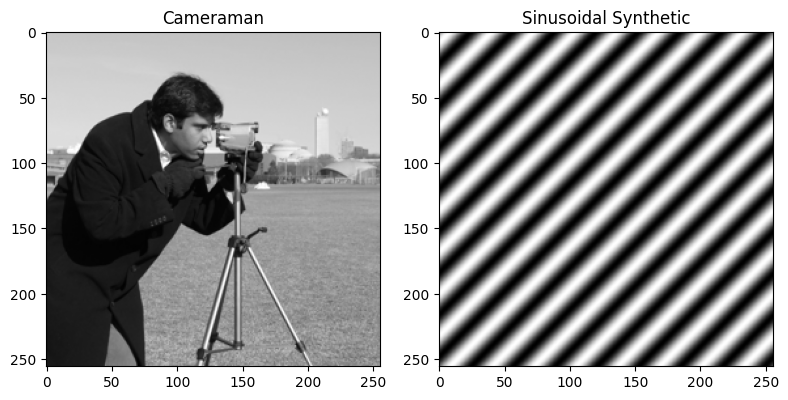

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.color import rgb2gray
from skimage import img_as_ubyte
from math import log2
import random
import cv2

# Example placeholders: replace with your own images
img_real = cv2.imread('Cameraman.png', cv2.IMREAD_GRAYSCALE)
img_synth = cv2.imread('Sinusoidal-Synthetic.png', cv2.IMREAD_GRAYSCALE)

# Resize to 256×256 (if needed)
img_real = cv2.resize(img_real, (256, 256))
img_synth = cv2.resize(img_synth, (256, 256))

# Display
plt.figure(figsize=(8,4))
plt.subplot(1,2,1); plt.imshow(img_real, cmap='gray'); plt.title("Cameraman")
plt.subplot(1,2,2); plt.imshow(img_synth, cmap='gray'); plt.title("Sinusoidal Synthetic")
plt.tight_layout()
plt.show()


## 🧩 Step 1: Preprocessing
Convert both images to grayscale and 8-bit integer format.

In [11]:
if img_real.ndim == 3:
    img_real = rgb2gray(img_real)
if img_synth.ndim == 3:
    img_synth = rgb2gray(img_synth)

img_real = img_as_ubyte(img_real)
img_synth = img_as_ubyte(img_synth)

print('Image shape:', img_real.shape)

Image shape: (256, 256)


## ⚙️ Step 2: Define Helper Functions
- **Entropy calculation** based on histogram probability distribution.

In [12]:
def entropy(image):
    hist, _ = np.histogram(image, bins=256, range=(0, 256))
    p = hist / np.sum(hist)
    p = p[p > 0]
    return -np.sum(p * np.log2(p))

## 🔄 Step 3: Flip 15% of Pixels in Each Bit Plane
For each bit plane (0 to 7), randomly flip 15% of bits, reconstruct the image, and measure **PSNR** and **Entropy**.

In [13]:
num_bits = 8
psnr_values = []
entropy_values = []
psnr_flipped = []

psnr_original = psnr(img_real, img_synth, data_range=255)

for k in range(num_bits):
    bit_plane = (img_synth >> k) & 1
    
    mask = np.random.rand(*bit_plane.shape) < 0.15
    flipped_plane = bit_plane.copy()
    flipped_plane[mask] = 1 - flipped_plane[mask]

    modified_img = img_synth.copy()
    # create uint8 mask
    mask_clear = np.uint8(255 - (1 << k))  # equivalent to ~ ensuring unsigned
    modified_img = np.bitwise_and(modified_img, mask_clear)
    modified_img = np.bitwise_or(modified_img, np.uint8(flipped_plane << k))

    psnr_val = psnr(img_real, modified_img, data_range=255)
    entropy_val = entropy(modified_img)

    psnr_values.append(psnr_val)
    entropy_values.append(entropy_val)
    psnr_flipped.append(psnr_original - psnr_val)

print('Analysis complete.')

Analysis complete.


## 📊 Step 4: Visualization
Plot the PSNR, Entropy, and PSNR change for all bit planes.

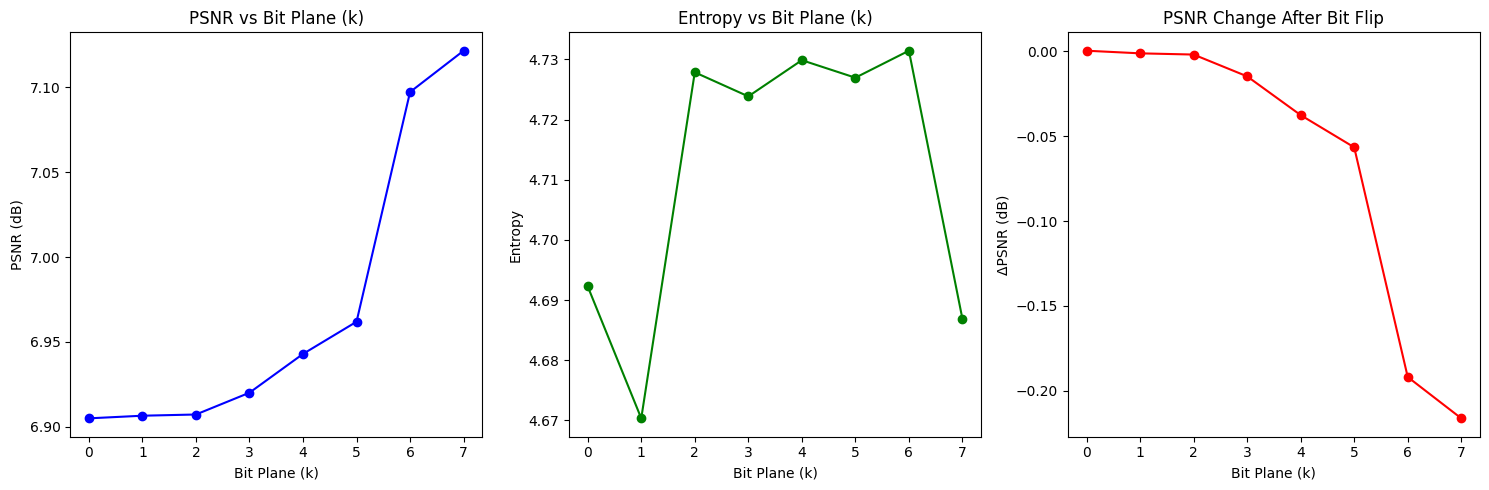

In [14]:
k_values = np.arange(num_bits)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(k_values, psnr_values, marker='o', color='blue')
plt.title('PSNR vs Bit Plane (k)')
plt.xlabel('Bit Plane (k)')
plt.ylabel('PSNR (dB)')

plt.subplot(1, 3, 2)
plt.plot(k_values, entropy_values, marker='o', color='green')
plt.title('Entropy vs Bit Plane (k)')
plt.xlabel('Bit Plane (k)')
plt.ylabel('Entropy')

plt.subplot(1, 3, 3)
plt.plot(k_values, psnr_flipped, marker='o', color='red')
plt.title('PSNR Change After Bit Flip')
plt.xlabel('Bit Plane (k)')
plt.ylabel('ΔPSNR (dB)')

plt.tight_layout()
plt.show()

## 📈 Step 5: Analysis
- Lower bit planes (0–2) cause smaller PSNR drop.
- Higher bit planes (5–7) introduce stronger noise → bigger PSNR decrease.
- Entropy tends to increase as more significant bits are flipped.